In [1]:
import pandas as pd
import numpy as np

column_names = ["user_id", "item_id", "rating", "timestamp"]

df = pd.read_csv("ml-100k/u.data", sep="\t", names=column_names)

In [2]:
df.head(3)

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116


In [3]:
#All integers
df.dtypes

user_id      int64
item_id      int64
rating       int64
timestamp    int64
dtype: object

In [4]:
#4 columns and 100000 rows
df.shape

(100000, 4)

In [5]:
#There are no null values
df.isna().sum()

user_id      0
item_id      0
rating       0
timestamp    0
dtype: int64

In [6]:
#Convert timestamp
from datetime import date

df["new_date"] = df["timestamp"].apply(lambda x: date.fromtimestamp(x))

df.head(3)

,user_id,item_id,rating,timestamp,new_date
0,196,242,3,881250949,1997-12-04
1,186,302,3,891717742,1998-04-04
2,22,377,1,878887116,1997-11-07


In [7]:
#Drop timestamp column
df.drop(columns=["timestamp"], inplace=True)

In [8]:
df.head(3)

,user_id,item_id,rating,new_date
0,196,242,3,1997-12-04
1,186,302,3,1998-04-04
2,22,377,1,1997-11-07


C:\Users\omerf\AppData\Local\Temp\ipykernel_5136\7338068.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = "rating" , data=df, palette="coolwarm")


<Axes: title={'center': 'Number of Movies by Their Rating'}, xlabel='Rating', ylabel='Count'>

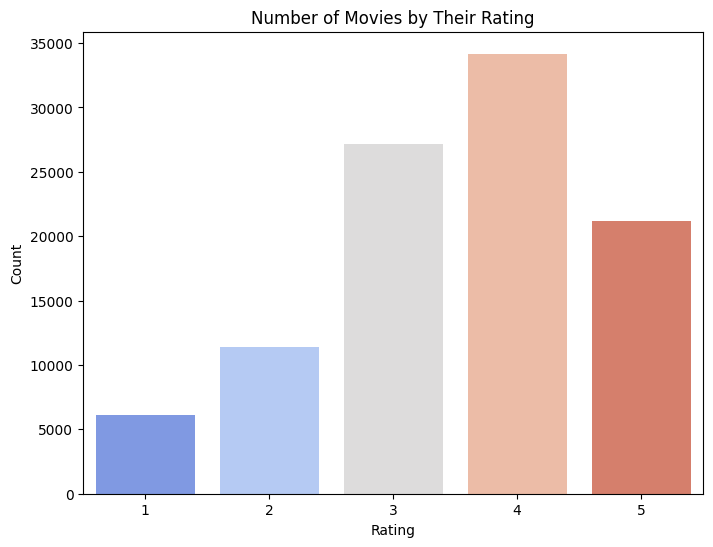

In [9]:
#A graph for fun
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.title("Number of Movies by Their Rating")
plt.xlabel("Rating")
plt.ylabel("Count")
sns.countplot(x = "rating" , data=df, palette="coolwarm")


#Most of the movies have 4 ratings

In [10]:
#Split dataset into training and test sets
from sklearn.model_selection import train_test_split

X = df[["user_id", "item_id"]]
y = df["rating"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Model Review

I read these 2 articles on Medium to get started, explains item-based and user-based collaborative filtering in a simple way - https://medium.com/@cfpinela/recommender-systems-user-based-and-item-based-collaborative-filtering-5d5f375a127f , https://medium.com/@iremcilingir/%C3%B6neri-sistemleri-recommendation-systems-28a3f341c0a9

After that I read this article for further explanation - https://onlinelibrary.wiley.com/doi/full/10.1155/2009/421425

For matrix factorization I read this post on Medium - https://towardsdatascience.com/recommendation-system-matrix-factorization-d61978660b4b




1 - User-Based Collaborative Filtering

In [11]:
#Importing KNN for this task and metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score
best = []
def best_k():
    for k in range(1,50):
        neighbor = KNeighborsClassifier(n_neighbors=k)
        neighbor.fit(x_train,y_train)
        prediction = neighbor.predict(x_test)
        recall = precision_score(y_test,prediction,average="weighted")
        best.append(recall)
best_k()

<Axes: >

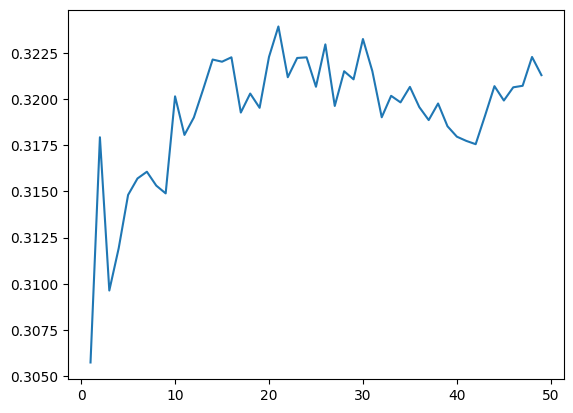

In [12]:
sns.lineplot(y=best, x = range(1,50))
#k = 21 is the best

In [13]:
neighbor = KNeighborsClassifier(n_neighbors=21)
neighbor.fit(x_train,y_train)
prediction = neighbor.predict(x_test)

In [14]:
print(f"Recall score is : {recall_score(y_test,prediction, average="weighted"):.4f}")
print(f"Precision score is : {precision_score(y_test,prediction, average="weighted"):.4f}")

Recall score is : 0.3398
Precision score is : 0.3239


In [15]:
def hit_ratio(y_test, prediction):
    hits = sum(1 for true, pred in zip(y_test, prediction) if true == pred)
    return hits / len(y_test)

hit_ratio_value = hit_ratio(y_test, prediction)
print(f'Hit Ratio: {hit_ratio_value:.4f}')

Hit Ratio: 0.3398


In [16]:
y_test = np.array(y_test)
prediction = np.array(prediction)

In [17]:
#I couldn't do it with sklearn ndcg so I used this code from internet
def dcg_score(y_true, y_score, k):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    gains = 2 ** y_true - 1
    discounts = np.log2(np.arange(2, y_true.size + 2))
    return np.sum(gains / discounts)

def ndcg_score(y_true, y_score, k=21):
    best_dcg = dcg_score(y_true, y_true, k) #IDCG best DCG score
    actual_dcg = dcg_score(y_true, y_score, k)
    return actual_dcg / best_dcg if best_dcg > 0 else 0

k = 10
ndcg_value = ndcg_score(y_test, prediction, k)
print(f'NDCG score is: {ndcg_value:.4f}')

NDCG score is: 0.4328


Item-Based Colaborative Filtering

In [18]:
#We'll use scikit-surprise
from surprise import Dataset, Reader, KNNBasic
from surprise.trainset import Trainset

In [19]:
df['user_id'] = df['user_id'].astype('int32')
df['item_id'] = df['item_id'].astype('int32')
df['rating'] = df['rating'].astype('float32')

In [20]:
#Preparing train data and test data
reader = Reader(rating_scale=(1,5))

train_data = Dataset.load_from_df(pd.DataFrame({'user_id' : x_train['user_id'],
                                                "item_id" : x_train["item_id"],
                                                "rating": y_train}), reader)

In [21]:
test_data = Dataset.load_from_df(pd.DataFrame({'user_id': x_test['user_id'], 
                                               'item_id': x_test['item_id'], 
                                               'rating': y_test}), reader)

In [22]:
#Convert to train and test set
trainset = train_data.build_full_trainset()
testset = test_data.construct_testset(test_data.raw_ratings)

In [23]:
#Item-based coll. filtering algorithm with cosine similarity

algorithm = KNNBasic(sim_options = {"name": "cosine", "user_based": False})

In [24]:
#Train the model
algorithm.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [25]:
#Make predictions
predictions = algorithm.test(testset)

In [26]:
predictions

[Prediction(uid=877, iid=381, r_ui=4.0, est=4.025975954077053, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=815, iid=602, r_ui=3.0, est=3.8974259689031907, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=94, iid=431, r_ui=4.0, est=3.4716670443683575, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=416, iid=875, r_ui=2.0, est=3.424911497800724, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=500, iid=182, r_ui=2.0, est=3.6203376166616064, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=259, iid=1074, r_ui=3.0, est=3.8999144456741233, details={'actual_k': 38, 'was_impossible': False}),
 Prediction(uid=598, iid=286, r_ui=5.0, est=3.5693567849996595, details={'actual_k': 18, 'was_impossible': False}),
 Prediction(uid=886, iid=496, r_ui=4.0, est=3.5243738175861763, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=837, iid=15, r_ui=3.0, est=3.0038575800757057, details={'a

In [27]:
#Real and estimated values
y_true = [pred.r_ui for pred in predictions]
y_pred = [pred.est for pred in predictions] 

In [28]:
#Round the predicted values
rounded_y = [round(pred) for pred in y_pred]

In [29]:
precision = precision_score(y_true, rounded_y, average='weighted')
recall = recall_score(y_true, rounded_y, average='weighted')

In [30]:
print(f"Precision is : {precision}")
print(f"Recall is : {recall}")

Precision is : 0.4260370304066345
Recall is : 0.3812


In [31]:
#NDCG score 
ndcg = ndcg_score(y_true,rounded_y)

In [32]:
print(f"NDCG score is : {ndcg:.4f}")

NDCG score is : 0.7947


In [33]:
#Hit ratio
def hit_ratio_at_1(y_true,rounded_y):
    hits = sum(1 for true, pred in zip(y_true, rounded_y) if true == pred)
    return hits / len(y_test)

hit_ratio = hit_ratio_at_1(y_true,rounded_y)

print(f"Hit ratio is : {hit_ratio:.4f}")

Hit ratio is : 0.3812


Matrix Factorization

In [34]:
#Again I will use scikit-surprise
from surprise import SVD

In [35]:
#Defining a variable as SVD function
alg = SVD()

In [36]:
alg.fit(trainset)

In [37]:
predicted = alg.test(testset)

In [38]:
predicted

[Prediction(uid=877, iid=381, r_ui=4.0, est=3.8919438110418576, details={'was_impossible': False}),
 Prediction(uid=815, iid=602, r_ui=3.0, est=3.815421994264862, details={'was_impossible': False}),
 Prediction(uid=94, iid=431, r_ui=4.0, est=3.434527285429268, details={'was_impossible': False}),
 Prediction(uid=416, iid=875, r_ui=2.0, est=3.1571120367378356, details={'was_impossible': False}),
 Prediction(uid=500, iid=182, r_ui=2.0, est=4.110909129857421, details={'was_impossible': False}),
 Prediction(uid=259, iid=1074, r_ui=3.0, est=3.4458507459505703, details={'was_impossible': False}),
 Prediction(uid=598, iid=286, r_ui=5.0, est=3.7063466514672236, details={'was_impossible': False}),
 Prediction(uid=886, iid=496, r_ui=4.0, est=3.6627297010586872, details={'was_impossible': False}),
 Prediction(uid=837, iid=15, r_ui=3.0, est=3.3772657381237288, details={'was_impossible': False}),
 Prediction(uid=521, iid=184, r_ui=4.0, est=3.478330397368388, details={'was_impossible': False}),
 Pred

In [39]:
y_trues = np.array([pred.r_ui for pred in predicted])
y_preds = np.array([pred.est for pred in predicted])

In [40]:
y_trues, y_preds

(array([4., 3., 4., ..., 4., 4., 3.]),
 array([3.89194381, 3.81542199, 3.43452729, ..., 4.11680237, 3.3895928 ,
        3.20622233]))

In [41]:
rounded = np.array([round(pred.est) for pred in predicted])
precis = precision_score(y_trues, rounded, average = "weighted")
reca = recall_score(y_trues,rounded, average = "weighted")
ndcgs = ndcg_score(y_trues, rounded, k=10)

In [42]:
print(f"NDCG is : {ndcgs:.4f}")
print(f"Precision is : {precis:.4f}")
print(f"Recall is : {reca:.4f}")

NDCG is : 0.6272
Precision is : 0.4677
Recall is : 0.4189


Recommendation to calculate NDCG score and Hit ratio

In [43]:
#I'm gonna do it all over again from data reading to prepare it and split it
import pandas as pd
import numpy as np

column_names = ["user_id", "item_id", "rating", "timestamp"]

df = pd.read_csv("ml-100k/u.data", sep="\t", names=column_names)

In [44]:
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [45]:
#I know that there is no null values so i skipped to the converting timestamp part
from datetime import date

df["new_date"] = df["timestamp"].apply(lambda x: date.fromtimestamp(x))

df.head(3)

,user_id,item_id,rating,timestamp,new_date
0,196,242,3,881250949,1997-12-04
1,186,302,3,891717742,1998-04-04
2,22,377,1,878887116,1997-11-07


In [46]:
df.drop(columns=["timestamp"], inplace=True)

In [47]:
df.head()

,user_id,item_id,rating,new_date
0,196,242,3,1997-12-04
1,186,302,3,1998-04-04
2,22,377,1,1997-11-07
3,244,51,2,1997-11-27
4,166,346,1,1998-02-02


In [48]:
df['new_date'] = pd.to_datetime(df['new_date'])

In [49]:
df.head()

,user_id,item_id,rating,new_date
0,196,242,3,1997-12-04
1,186,302,3,1998-04-04
2,22,377,1,1997-11-07
3,244,51,2,1997-11-27
4,166,346,1,1998-02-02


In [50]:
#Splitting the data (I will use test set as last six month and will)
from sklearn.model_selection import train_test_split

date_cut = df["new_date"].max() - pd.DateOffset(months=6)

train = df[df["new_date"] < date_cut]
test = df[df["new_date"] >= date_cut]

In [51]:
#I'll use scikit-surprise library for recommendation
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy

reader = Reader(rating_scale=(1,5))
train_data = Dataset.load_from_df(train[['user_id', 'item_id', 'rating']], reader)
test_data = Dataset.load_from_df(test[['user_id', 'item_id', 'rating']], reader)

trainset = train_data.build_full_trainset()
testset = test_data.build_full_trainset().build_testset()

In [52]:
sim_options = {
    "name" : "cosine",
    "user_based" : False
}

model = KNNBasic(sim_options=sim_options)

model.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [53]:
predictions_r = model.test(testset)

In [54]:
predictions_r

[Prediction(uid=196, iid=242, r_ui=3.0, est=3.562773822562979, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=196, iid=393, r_ui=4.0, est=3.562773822562979, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=196, iid=381, r_ui=4.0, est=3.562773822562979, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=196, iid=251, r_ui=3.0, est=3.562773822562979, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=196, iid=655, r_ui=5.0, est=3.562773822562979, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=196, iid=67, r_ui=5.0, est=3.562773822562979, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=196, iid=306, r_ui=4.0, est=3.562773822562979, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=196, 

In [70]:
#Recommendations based on predictions
def top_10(predictions_r, n = 10):
    top_n = {}
    #User id's and recommended items and their ratings
    for uid, iid, est, _ , true_r in predictions_r:
        if not top_n.get(uid):
            top_n[uid] = []
        top_n[uid].append((iid, round(est)))

    #For recommendtiong top 10 
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [71]:
recommendations = top_10(predictions_r, n=10)

In [74]:
recommendations

{196: [(655, 5),
  (67, 5),
  (663, 5),
  (286, 5),
  (692, 5),
  (8, 5),
  (285, 5),
  (153, 5),
  (393, 4),
  (381, 4)],
 186: [(566, 5),
  (470, 5),
  (925, 5),
  (322, 5),
  (71, 5),
  (44, 5),
  (117, 5),
  (939, 5),
  (226, 5),
  (300, 5)],
 22: [(128, 5),
  (258, 5),
  (510, 5),
  (173, 5),
  (186, 5),
  (96, 5),
  (403, 5),
  (435, 5),
  (176, 5),
  (550, 5)],
 244: [(154, 5),
  (89, 5),
  (652, 5),
  (238, 5),
  (743, 5),
  (237, 5),
  (509, 5),
  (101, 5),
  (179, 5),
  (208, 5)],
 166: [(328, 5),
  (322, 5),
  (300, 5),
  (323, 5),
  (984, 5),
  (347, 5),
  (313, 5),
  (258, 4),
  (343, 4),
  (894, 4)],
 298: [(8, 5),
  (498, 5),
  (496, 5),
  (237, 5),
  (502, 5),
  (651, 5),
  (71, 5),
  (178, 5),
  (483, 5),
  (527, 5)],
 115: [(8, 5),
  (127, 5),
  (234, 5),
  (530, 5),
  (466, 5),
  (511, 5),
  (642, 5),
  (32, 5),
  (475, 5),
  (89, 5)],
 253: [(465, 5),
  (510, 5),
  (183, 5),
  (483, 5),
  (198, 5),
  (127, 5),
  (173, 5),
  (527, 5),
  (117, 5),
  (87, 5)],
 305: [(